In [1]:
import os
import tqdm
import random
import pathlib
import itertools
import collections

import cv2
import einops
import numpy as np
import remotezip as rz
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import layers

from pathlib import Path

In [2]:
#@title

def get_files_per_class(pathToData):
  """
    Retrieve the files that belong to each class for a certain data subset: train, validation or test. 

    Args:
      pathToData: Path to the data folder containing all the videos ordered by class.

    Return:
      Dictionary of class names (key) and files path (values).
  """
  files_for_class = collections.defaultdict(list)
  
  for classFolder in sorted(os.listdir(pathToData)): 
      pathToClassFolder = os.path.join(pathToData, classFolder)
      if not classFolder.startswith(".") and os.path.isdir(pathToClassFolder):
          for file in sorted(os.listdir(pathToClassFolder)):
              if (not file.startswith(".")) and (file.endswith(".mp4")):
                  pathToFile = os.path.join(pathToClassFolder, file)
                  files_for_class[classFolder].append(pathToFile)

  return files_for_class

def splitTrainTest(files, test_size=0.1, random_state=0):
    """
    Split data into training and test set

    Parameters
    ----------
    files : dictionnary
        Dictionary of class names (key) and files path (values).
    test_size : float, optional
        Size of the test set, by default 0.2
    random_state : int, optional
        Random state, by default 0

    Returns
    -------
    tuple of dictionnaries
        trainSubset, testSubset

    """
    trainSubset = collections.defaultdict(list)
    testSubset = collections.defaultdict(list)
    for key in files:
      if random_state:
        np.random.seed(random_state)
      np.random.shuffle(files[key])
      trainSubset[key].append(files[key][int(len(files[key])*test_size):])
      trainSubset[key] = [item for row in trainSubset[key] for item in row]
      testSubset[key].append(files[key][:int(len(files[key])*test_size)])
      testSubset[key] = [item for row in testSubset[key] for item in row]
    return trainSubset, testSubset

#TODO: use pose-estimation bounding box as output_size
def format_frames(frame, output_size):
  """
    Pad and resize an image from a video.
    
    Args:
      frame: Image that needs to resized and padded. 
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame

def frames_from_video_file(video_path, n_frames, output_size = (224,224), frame_step = 15):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))  

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result

class FrameGenerator:
  def __init__(self, path, n_frames, training = False):
    """ Returns a set of frames with their associated label. 

      Args:
        path: Video file paths.
        n_frames: Number of frames. 
        training: Boolean to determine if training dataset is being created.
    """
    self.path = path
    self.n_frames = n_frames
    self.training = training
    self.class_names = sorted(set(self.path.keys()))
    self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

  def get_files_and_class_names(self):
    temp = list(x for l in self.path.values() for x in l)
    video_paths = temp
    classes = [Path(p).parent.name for p in video_paths]
    return video_paths, classes

  def __call__(self):
    video_paths, classes = self.get_files_and_class_names()

    pairs = list(zip(video_paths, classes))

    if self.training:
      random.shuffle(pairs)

    for path, name in pairs:
      video_frames = frames_from_video_file(path, self.n_frames) 
      label = self.class_ids_for_name[name] # Encode labels
      yield video_frames, label

In [3]:
trainSubSet = '/Users/nathansadoun/Desktop/INSA/ML/Video_classification/MediaEval_ClassificationTask/data/classificationTask/train'
validationSubSet = '/Users/nathansadoun/Desktop/INSA/ML/Video_classification/MediaEval_ClassificationTask/data/classificationTask/validation'

In [4]:
n_frames = 100
batch_size = 8

output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))

trainvalidtest = get_files_per_class(trainSubSet)
traintest, validation = splitTrainTest(trainvalidtest, test_size=0.3)
train, test = splitTrainTest(traintest, test_size=0.1)

train_ds = tf.data.Dataset.from_generator(FrameGenerator(train, n_frames, training=True),
                                          output_signature = output_signature)


# Batch the data
train_ds = train_ds.batch(batch_size)

val_ds = tf.data.Dataset.from_generator(FrameGenerator(validation, n_frames),
                                        output_signature = output_signature)
val_ds = val_ds.batch(batch_size)

test_ds = tf.data.Dataset.from_generator(FrameGenerator(test, n_frames),
                                         output_signature = output_signature)

test_ds = test_ds.batch(batch_size)

In [5]:
train

defaultdict(list,
            {'Defensive Backhand Backspin': ['/Users/nathansadoun/Desktop/INSA/ML/Video_classification/MediaEval_ClassificationTask/data/classificationTask/train/Defensive Backhand Backspin/8348883210.mp4',
              '/Users/nathansadoun/Desktop/INSA/ML/Video_classification/MediaEval_ClassificationTask/data/classificationTask/train/Defensive Backhand Backspin/947687719.mp4',
              '/Users/nathansadoun/Desktop/INSA/ML/Video_classification/MediaEval_ClassificationTask/data/classificationTask/train/Defensive Backhand Backspin/357494546.mp4',
              '/Users/nathansadoun/Desktop/INSA/ML/Video_classification/MediaEval_ClassificationTask/data/classificationTask/train/Defensive Backhand Backspin/7641017885.mp4',
              '/Users/nathansadoun/Desktop/INSA/ML/Video_classification/MediaEval_ClassificationTask/data/classificationTask/train/Defensive Backhand Backspin/4102951825.mp4',
              '/Users/nathansadoun/Desktop/INSA/ML/Video_classification/M

In [6]:
# Define the dimensions of one frame in the set of frames created
HEIGHT = 224
WIDTH = 224

In [7]:
class Conv2Plus1D(keras.layers.Layer):
  def __init__(self, filters, kernel_size, padding):
    """
      A sequence of convolutional layers that first apply the convolution operation over the
      spatial dimensions, and then the temporal dimension. 
    """
    super().__init__()
    self.seq = keras.Sequential([  
        # Spatial decomposition
        layers.Conv3D(filters=filters,
                      kernel_size=(1, kernel_size[1], kernel_size[2]),
                      padding=padding),
        # Temporal decomposition
        layers.Conv3D(filters=filters, 
                      kernel_size=(kernel_size[0], 1, 1),
                      padding=padding)
        ])
  
  def call(self, x):
    return self.seq(x)

In [8]:
class ResidualMain(keras.layers.Layer):
  """
    Residual block of the model with convolution, layer normalization, and the
    activation function, ReLU.
  """
  def __init__(self, filters, kernel_size):
    super().__init__()
    self.seq = keras.Sequential([
        Conv2Plus1D(filters=filters,
                    kernel_size=kernel_size,
                    padding='same'),
        layers.LayerNormalization(),
        layers.ReLU(),
        Conv2Plus1D(filters=filters, 
                    kernel_size=kernel_size,
                    padding='same'),
        layers.LayerNormalization()
    ])
    
  def call(self, x):
    return self.seq(x)

In [9]:
class Project(keras.layers.Layer):
  """
    Project certain dimensions of the tensor as the data is passed through different 
    sized filters and downsampled. 
  """
  def __init__(self, units):
    super().__init__()
    self.seq = keras.Sequential([
        layers.Dense(units),
        layers.LayerNormalization()
    ])

  def call(self, x):
    return self.seq(x)

In [10]:
def add_residual_block(input, filters, kernel_size):
  """
    Add residual blocks to the model. If the last dimensions of the input data
    and filter size does not match, project it such that last dimension matches.
  """
  out = ResidualMain(filters, 
                     kernel_size)(input)
  
  res = input
  # Using the Keras functional APIs, project the last dimension of the tensor to
  # match the new filter size
  if out.shape[-1] != input.shape[-1]:
    res = Project(out.shape[-1])(res)

  return layers.add([res, out])

In [11]:
class ResizeVideo(keras.layers.Layer):
  def __init__(self, height, width):
    super().__init__()
    self.height = height
    self.width = width
    self.resizing_layer = layers.Resizing(self.height, self.width)

  def call(self, video):
    """
      Use the einops library to resize the tensor.  
      
      Args:
        video: Tensor representation of the video, in the form of a set of frames.
      
      Return:
        A downsampled size of the video according to the new height and width it should be resized to.
    """
    # b stands for batch size, t stands for time, h stands for height, 
    # w stands for width, and c stands for the number of channels.
    old_shape = einops.parse_shape(video, 'b t h w c')
    images = einops.rearrange(video, 'b t h w c -> (b t) h w c')
    images = self.resizing_layer(images)
    videos = einops.rearrange(
        images, '(b t) h w c -> b t h w c',
        t = old_shape['t'])
    return videos

In [12]:
input_shape = (None, 10, HEIGHT, WIDTH, 3)
input = layers.Input(shape=(input_shape[1:]))
x = input

x = Conv2Plus1D(filters=16, kernel_size=(3, 7, 7), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = ResizeVideo(HEIGHT // 2, WIDTH // 2)(x)

# Block 1
x = add_residual_block(x, 16, (3, 3, 3))
x = ResizeVideo(HEIGHT // 4, WIDTH // 4)(x)

# Block 2
x = add_residual_block(x, 32, (3, 3, 3))
x = ResizeVideo(HEIGHT // 8, WIDTH // 8)(x)

# Block 3
x = add_residual_block(x, 64, (3, 3, 3))
x = ResizeVideo(HEIGHT // 16, WIDTH // 16)(x)

# Block 4
x = add_residual_block(x, 128, (3, 3, 3))

x = layers.GlobalAveragePooling3D()(x)
x = layers.Flatten()(x)
x = layers.Dense(21)(x)

model = keras.Model(input, x)

In [13]:
frames, label = next(iter(train_ds))
model.build(frames)

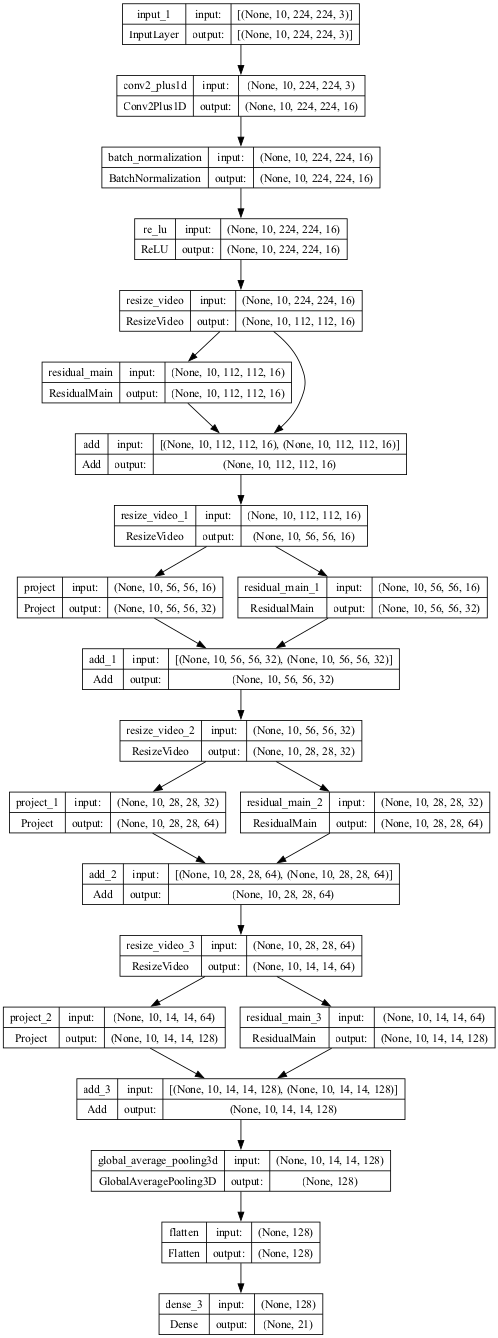

In [14]:
# Visualize the model
keras.utils.plot_model(model, expand_nested=True, dpi=60, show_shapes=True)

In [15]:
model.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              optimizer = keras.optimizers.legacy.Adam(learning_rate = 0.0001), 
              metrics = ['accuracy'])

In [16]:
history = model.fit(x = train_ds,
                    epochs = 50, 
                    validation_data = val_ds)

Epoch 1/50
      1/Unknown - 48s 48s/step - loss: 4.7959 - accuracy: 0.0000e+00